In [2]:
import findspark
import pandas as pd
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf

# for shared metastore (shared across all users)
spark = SparkSession.builder.appName("Identification").config("hive.metastore.uris", "thrift://bialobog:9083", conf=SparkConf()).getOrCreate() \

# for local metastore (your private, invidivual database) add the following config to spark session

spark.catalog.listDatabases()

[Database(name='2022_10_22', catalog='spark_catalog', description='FactSet data version for the day', locationUri='hdfs://bialobog.cs.ucl.ac.uk:8020/user/hive/warehouse'),
 Database(name='2023_04_01', catalog='spark_catalog', description='FactSet data version for the day', locationUri='hdfs://bialobog.cs.ucl.ac.uk:8020/user/hive/warehouse'),
 Database(name='default', catalog='spark_catalog', description='Default Hive database', locationUri='hdfs://bialobog.cs.ucl.ac.uk:8020/user/hive/warehouse')]

In [3]:
from pyspark.sql.functions import regexp_replace

spark.sql("USE 2023_04_01")
    # Assuming that 'ticker' is a valid Python variable





DataFrame[]

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from datetime import datetime
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from pyspark.sql import Row
from pyspark.sql.functions import col, to_date, lit
from datetime import timedelta
from pyspark.sql.types import StructType, StructField, StringType, DateType
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import csv
import math


start_date = '2001-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

def get_stock_price_weekly(ticker):
    # Suppress the progress message from yfinance
    temp_df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if temp_df.empty:
        #print("No data available for the specified date range.")
        return None
    weekly_data = temp_df['Adj Close'].resample('W').last()
    return weekly_data

def get_stock_prices(ticker):
    # Suppress the progress message from yfinance
    query = f"""SELECT s.ticker_region, p.p_date, p.p_price FROM sym_ticker_region s 
                LEFT JOIN FF_SEC_COVERAGE c ON c.fsym_id = s.fsym_id
                LEFT JOIN sym_coverage sc ON sc.fsym_id = s.fsym_id
                LEFT JOIN fp_basic_prices p ON p.fsym_id = s.fsym_id
                WHERE s.ticker_region LIKE "%-US" AND s.ticker_region NOT LIKE '%.%' AND c.CURRENCY = "USD"
                AND (sc.fref_listing_exchange = "NAS" OR sc.fref_listing_exchange = "NYS")
                ORDER BY p.p_date"""
    df = spark.sql(query)
    df.show(10)

def plot_price(ticker):
    # Suppress the progress message from yfinance
    temp_df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if temp_df.empty:
        #print("No data available for the specified date range.")
        return None
    weekly_data = temp_df['Adj Close'].resample('W').last()
    plt.figure(figsize=(15, 5))
    plt.plot(weekly_data.index, weekly_data, label=ticker)
    plt.legend()
    plt.show()
    
def plot_cum_returns(ticker):
    # Suppress the progress message from yfinance
    temp_df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if temp_df.empty:
        #print("No data available for the specified date range.")
        return None
    weekly_data = temp_df['Adj Close'].resample('W').last().to_frame()
    print(weekly_data.head())
    weekly_data['returns']  = weekly_data['Adj Close'].pct_change()
    weekly_data['cumulative_returns'] = (1 + weekly_data['returns']).cumprod() - 1
    plt.figure(figsize=(15, 5))
    plt.plot(weekly_data.index, weekly_data['cumulative_returns'], label=ticker)
    #plt.plot(weekly_data.index, weekly_data['Adj Close'], color='yellow')
    plt.legend()
    plt.show()

def check_implosion(idx, firm_price, imp_thresh):
    i = idx
    start_price=firm_price.iloc[idx]
    i+=1
    period=0
    while i < len(firm_price):
        current_date = firm_price.index[i]
        current_price = firm_price.iloc[i]
        imp_price_period = firm_price[firm_price.index[i-10] : firm_price.index[i]]
        if (current_price-start_price)/start_price > 0.3:
            return period
        period+=1
        i+=1
    return period

def get_crash_dates(firm_price, price_drop_thresh=-0.6, period_thresh=52):
    crash_dates = []
    imp_dates = []
    i = 52
    while i < len(firm_price):
        current_date = firm_price.index[i]
        current_price = firm_price.iloc[i]
        prev_year_data = firm_price.iloc[i-52:i]
        if len(prev_year_data) != 0:
            mean_price = prev_year_data.mean()
            if (current_price - mean_price)/mean_price < price_drop_thresh:
                imp_dates.append(current_date)
        i+=1
    return imp_dates

def get_implosion_dates(firm_price, price_drop_thresh=-0.6, period_thresh=52):
    crash_dates = []
    imp_dates = []
    i = 52
    while i < len(firm_price):
        current_date = firm_price.index[i]
        current_price = firm_price.iloc[i]
        prev_year_data = firm_price.iloc[i-52:i]
        if len(prev_year_data) != 0:
            mean_price = prev_year_data.mean()
            if (current_price - mean_price)/mean_price < price_drop_thresh:
                imp_period = check_implosion(i, firm_price,  price_drop_thresh)
                st_date = current_date
                end_date = firm_price.index[i+imp_period]
                imp_period_price = firm_price[st_date:end_date]
                if imp_period > period_thresh:
                    imp_dates.append((current_date, firm_price.index[i+imp_period]))
                i+=imp_period
        i+=1
    return imp_dates

def plot_implosions(stock_series, imp_dates, ticker, ax):
    #plt.figure(figsize=(15, 5))
    ax.plot(stock_series.index, stock_series, label=ticker)
    for i in imp_dates:
        ax.axvspan(i[0], i[1], alpha=0.5, color='blue')
    ax.legend()
    #plt.show()

# def run_imps(stocks_list):
#     num_imp = 0
#     j = 0
#     fig, axs = plt.subplots(nrows=len(stocks_list), figsize=(15, 5*len(stocks_list)))
#     # for t in stocks_list:
#     #     stock_series = get_stock_price_weekly(t)
#     #     if stock_series is not None:
#     #         imp_dates = get_implosion_dates(stock_series)
#     #         if j % 10 == 0:
#     #             plot_implosions(stock_series, imp_dates, t, axs)    
#     #         j+=1
#     #         if len(imp_dates) >= 1:
#     #             num_imp+=1
#     #         # if len(imp_dates) ==0:
#     #         #     plot_implosions(stock_series, imp_dates, t)
#     # print(f"{num_imp} out of {j} imploded")
#     # plt.savefig('all_implosions.png')
#     # plt.close()
#     # return num_imp
#     for t, ax in zip(stocks_list, axs):
#         stock_series = get_stock_price_weekly(t)
#         if stock_series is not None:
#             imp_dates = get_implosion_dates(stock_series)
            
#             # Plot every 10th graph
#             if j % 10 == 0:
#                 plot_implosions(stock_series, imp_dates, t, ax=ax)
            
#             j += 1

#             if len(imp_dates) >= 1:
#                 num_imp += 1
    
#     # Save the final figure after the loop
#     plt.savefig('all_implosions_subplots.png')
    
#     # Close the Matplotlib figure to release resources
#     plt.close()
    
#     print(f"{num_imp} out of {j} imploded")
#     return num_imp
def run_imps(stocks_list, columns=3):
    num_imp = 0
    j = 0

    # Calculate the number of rows needed based on the number of stocks and columns
    num_rows = math.ceil(len(stocks_list) / columns)

    # Create a single Matplotlib figure with subplots
    fig, axs = plt.subplots(nrows=num_rows, ncols=columns, figsize=(15, 5*num_rows))

    for t, ax in zip(stocks_list, axs.flatten()):
        stock_series = get_stock_price_weekly(t)
        if stock_series is not None and max(stock_series) >= 100:
            imp_dates = get_implosion_dates(stock_series)
            
            # Plot every 10th graph
            
            plot_implosions(stock_series, imp_dates, t, ax=ax)
            
            j += 1

            if len(imp_dates) >= 1:
                num_imp += 1
    
    # Remove empty subplots if there are fewer stocks than the total number of subplots
    for i in range(len(stocks_list), num_rows * columns):
        fig.delaxes(axs.flatten()[i])
    
    # Adjust layout for better spacing
    plt.tight_layout()
    
    # Save the final figure after the loop
    plt.savefig('all_implosions_subplots.png')
    
    # Close the Matplotlib figure to release resources
    plt.close()
    
    print(f"{num_imp} out of {j} imploded")
    return num_imp


def plot_crashes(ticker):
    stock_series = get_stock_price_weekly(ticker)
    crash_dates = get_crash_dates(stock_series)
    plt.figure(figsize=(15, 5))
    plt.plot(stock_series.index, stock_series, label=ticker)
    for c in crash_dates:
        plt.axvspan(c,c, alpha=0.5, color='blue')
    plt.legend()
    plt.show()

def get_all_stocks():
    query = f"""SELECT s.ticker_region, sc.fref_listing_exchange FROM sym_ticker_region s 
                LEFT JOIN FF_SEC_COVERAGE c ON c.fsym_id = s.fsym_id
                LEFT JOIN sym_coverage sc ON sc.fsym_id = s.fsym_id
                WHERE s.ticker_region LIKE "%-US" AND s.ticker_region NOT LIKE '%.%' AND c.CURRENCY = "USD"
                AND (sc.fref_listing_exchange = "NAS" OR sc.fref_listing_exchange = "NYS")"""
    df = spark.sql(query)
    df = df.withColumn("ticker_region", regexp_replace("ticker_region", "-US$", ""))
    ticker_list = [row.ticker_region for row in df.collect()]
    return ticker_list

def get_all_stocks_df():
    query = f"""SELECT s.ticker_region, s.fsym_id FROM sym_ticker_region s 
                LEFT JOIN FF_SEC_COVERAGE c ON c.fsym_id = s.fsym_id
                LEFT JOIN sym_coverage sc ON sc.fsym_id = s.fsym_id
                WHERE s.ticker_region LIKE "%-US" AND s.ticker_region NOT LIKE '%.%' AND c.CURRENCY = "USD"
                AND (sc.fref_listing_exchange = "NAS" OR sc.fref_listing_exchange = "NYS")"""
    df = spark.sql(query)
    df = df.withColumn("ticker_region", regexp_replace("ticker_region", "-US$", ""))
    return df

def create_imploded_df(ticker_list):
    df = pd.read_csv('imploded_tickers_dates_test.csv', index_col=None, usecols=['Ticker','Implosion_Date'])
    #df = spark.createDataFrame([], schema)
    i = 0
    for t in ticker_list:
        stock_series = get_stock_price_weekly(t)
        if stock_series is not None and max(stock_series) >= 100:
            imp_dates = get_implosion_dates(stock_series)
            if len(imp_dates)!=0:
                for date in imp_dates:
                    date_str = pd.to_datetime(date[0]).strftime('%Y-%m-%d')
                    new_row = pd.DataFrame({'Ticker': [t], 'Implosion_Date': [date_str]})
                    df = pd.concat([df, new_row], ignore_index=True)
        if i>0 and i % 100 == 0:
            print(i)
            #df=df.orderBy('Ticker')
            df=df.sort_values(by='Ticker')
            df.to_csv('imploded_stocks2.csv', index='False')
        i+=1
    print(df.head(10)) 
    df=df.sort_values(by='Ticker')
    # df=df.orderBy('Ticker')
    df.to_csv('imploded_stocks2.csv', index='False')


def create_imploded_df2(ticker_list):
    df = pd.read_csv('imploded_tickers_dates_test.csv', index_col=None, usecols=['Ticker','Implosion_Date'])
    #df = spark.createDataFrame([], schema)
    i = 0
    for t in ticker_list:
        stock_series = get_stock_price_weekly(t)
        if stock_series is not None and max(stock_series) >= 100:
            imp_dates = get_implosion_dates(stock_series)
            if len(imp_dates)!=0:
                for date in imp_dates:
                    date_str = pd.to_datetime(date[0]).strftime('%Y-%m-%d')
                    new_row = pd.DataFrame({'Ticker': [t], 'Implosion_Date': [date_str]})
                    df = pd.concat([df, new_row], ignore_index=True)
        if i>0 and i % 100 == 0:
            print(i)
            #df=df.orderBy('Ticker')
            df=df.sort_values(by='Ticker')
            df.to_csv('imploded_stocks2.csv', index='False')
        i+=1
    print(df.head(10)) 
    df=df.sort_values(by='Ticker')
    # df=df.orderBy('Ticker')
    df.to_csv('imploded_stocks2.csv', index='False')
    

# ticker_list = sorted(get_all_stocks()[:5000])

# create_imploded_df(ticker_list)
# df = pd.read_csv('imploded_stocks.csv')
# run_imps(df['Ticker'].unique().tolist()[:25])
#run_imps(['EMCMF'])
#add_labels_to_df('imploded_only.csv')
#plot_crashes('SEAC')
#APPN,CPS, FOSL, GRPN,PRLB, SEAC
#APPN has not imploded
#CPS has not imploded
#imploded: 377/433, sp500:  russell: 243/1754 imploded

# ticker_list = get_all_stocks()
# print(ticker_list)
# file_name = "all_stocks.csv"

# with open(file_name, mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(ticker_list)

with open('all_stocks.csv', mode='r') as file:
    reader = csv.reader(file)
    
    # Assuming there is only one row in the CSV file
    ticker_list = next(reader, None)
    
# # Display the data list
print(ticker_list)
create_imploded_df(ticker_list)
# df = pd.read_csv('imploded_stocks.csv')
# print(len(df['Ticker'].unique().tolist()))

['UGI', 'KOD', 'NKLA', 'TDMX', 'MYFW', 'HUDA', 'BRKR', 'SRL', 'MPWG', 'GDOT', 'STTZF', 'GNLN', 'ADI', 'COMS', 'ZU', 'PCON', 'EVTL', 'TOPS', 'GWH', 'CMLS', 'MSACU', 'SUMR', 'CPU', 'AGIO', 'KLLM', 'CPCL', 'QTEK', 'RENT', 'OEC', 'ETON', 'BGB', 'PRXL', 'ARIS', 'CNGLU', 'GGG', 'SFN910', 'ANGI', 'VLD', 'GLBK', 'HYZN', 'DLTH', 'CBRGU', 'MLAI', 'PROJ', 'MRCIY', 'GLGX', 'ILSE', 'SANW', 'IBA', 'ARVN', 'IMMU', 'TGVCU', 'AFBK', 'DZA', 'KURA', 'BYM', 'SKIL', 'CCBI', 'FMIV', 'WCAA', 'WEYS', 'NAT', 'SHAW', 'VCXA', 'LBTYK', 'MSSN', 'GTK', 'ATO', 'SKWD', 'AMEH', 'ENTU', 'SYPR', 'OMPT', 'FRAF', 'IFCJ', 'AEGN', 'S', 'SVV', 'ALTPU', 'BEER', 'RWDT', 'CSTM', 'BEXP', 'MEC', 'ZURA', 'ZAREIX', 'ANSL', 'PMIX', 'CMPX', 'IID', 'OEPWU', 'HCAT', 'GAB', 'IGTAU', 'MBRG', 'DNET', 'EVOJU', 'AZ', 'CMCSA', 'BPTH', 'VIRT', 'AFOP', 'QRTEB', 'CHRW', 'PSPC', 'MITAU', 'PAR', 'BGS', 'EVOK', 'JMIA', 'LMNR', 'EQT', 'GTM', 'SERA', 'AFB', 'PASG', 'FACA', 'UNCY', 'LEO', 'LEXEA', 'CVRR', 'AFBI', 'ITCI', 'GOAL', 'NVAL', 'GWACU', 'KNS


1 Failed download:
['TDMX']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['MPWG']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['STTZF']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['ZU']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['PCON']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['MSACU']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['SUMR']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['KLLM']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['CPCL']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['QTEK']: Exception('%ticker%

100



1 Failed download:
['PSPC']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['GTM']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['FACA']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['LEXEA']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['GOAL']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['GWACU']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['ACTTU']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['AUS']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['VTIQ']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['KATE']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 ->

200



1 Failed download:
['FEO']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['PCX']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['CBNJ']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['FSB']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['TA']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['STRD']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['LIVKU']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['VCAI']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['MDLK']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
[

300



1 Failed download:
['SGHLU']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['HAST']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['SGNT']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['MBFI']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['ANSI']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['IDBE']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['HRBC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['GACQU']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['LOCK']: Exception('%ticker%: No price data found, symbol

400



1 Failed download:
['MRD']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['HGSI']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['FICC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['ICXT']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['HMACU']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['MVK']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['VANS']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['LQI']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['URGI']: Exception('%ticker%:

500



1 Failed download:
['PDOT']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['VG']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['PGNS']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['MAKR']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['DHBCU']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['SCAQ']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['FMER']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['RNHDA']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['EEI']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download

600



1 Failed download:
['DUC']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['RBMG']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['CEMY50']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['ABNJ']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['AACQU']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['ESM']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['FDML']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['POGO']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['PLMT']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed downlo

700



1 Failed download:
['EBACU']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['TSBS']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['CHRK']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['AMTG']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['DSE']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['VEDL']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['MXWL']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['VENAU']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['VUSOU']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['HMLP']: Exception('%ticker%: No timezone found, symbol ma

800



1 Failed download:
['KVSC']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['PRAH']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['UBA']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['PKI']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['ONXS']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['OTRAU']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['DNBK']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")

1 Failed download:
['CAIOY']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['RBAK']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['MXIM']: Exception('%ticker%: No timezone found, 

900



1 Failed download:
['GNSC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['TEKCU']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['SGBK']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['SWBS']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['ISIG']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['TFM']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['ITMN']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-28)')

1 Failed download:
['DESR']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['MZXY10']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed downl

KeyboardInterrupt: 

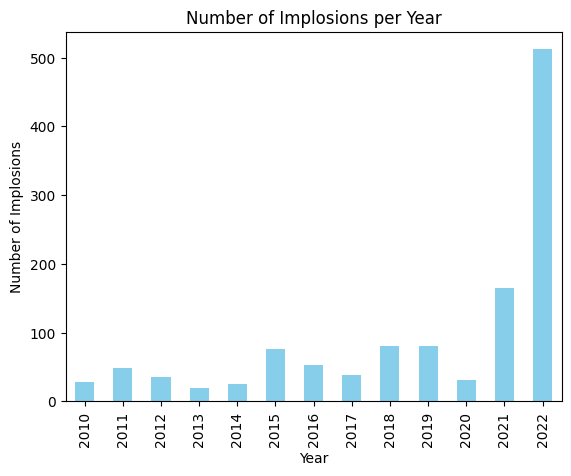

In [5]:
def visualize_implosions(df):
    df['Implosion_Date'] = pd.to_datetime(df['Implosion_Date'])
    df['year'] = df['Implosion_Date'].dt.year

    implosions_per_year = df.groupby('year').size()

    implosions_per_year.plot(kind='bar', color='skyblue')

    plt.title('Number of Implosions per Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Implosions')

    plt.show()
    
df = pd.read_csv('imploded_stocks.csv')
visualize_implosions(df)

In [ ]:
import pyspark.pandas as ps

def stock_start_analysis():
    stocks_df = spark.createDataFrame(pd.read_csv('imploded_stocks.csv'))
    stocks_df.createOrReplaceTempView("temp_table")
    query = f"""SELECT t.Ticker, c.p_first_date FROM temp_table t LEFT JOIN fp_sec_coverage c ON c.fsym_id=t.fsym_id
                    ORDER BY ticker_region
            """
    start_df = spark.sql(query)
    start_df = ps.DataFrame(start_df)
    start_df['Year'] = start_df['p_first_date'].dt.year
    print(start_df.head())
    starts_per_year = start_df.groupby('Year').size()
    print(starts_per_year.head())
    
    
    starts_per_year.plot(kind='bar')

    plt.title('Earliest dates of stocks')
    plt.xlabel('Year')
    plt.ylabel('Number of Stocks')

    plt.show()
    
#stock_start_analysis()
    
        

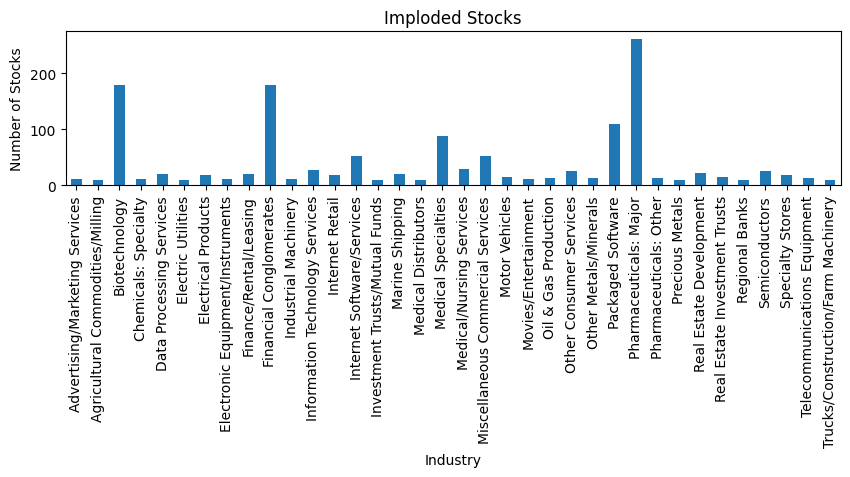

In [48]:
def industry_analysis_all():
    #stock_df = get_all_stocks_df()
    stock_df = pd.read_csv('imploded_stocks.csv')
    stock_df = spark.createDataFrame(stock_df)
    stock_df.createOrReplaceTempView("temp_table")
    q = """SELECT t.ticker_region, e.factset_industry_desc FROM temp_table t
    LEFT JOIN sym_coverage sc ON sc.fsym_id = t.fsym_id
    LEFT JOIN ff_sec_entity_hist c on c.fsym_id=sc.fsym_security_id
    LEFT JOIN sym_entity_sector d on d.factset_entity_id=c.factset_entity_id
    LEFT JOIN factset_industry_map e on e.factset_industry_code=d.industry_code
    ORDER BY t.ticker_region
    """
    q2 = """SELECT t.Ticker, e.factset_industry_desc FROM temp_table t
    LEFT JOIN sym_ticker_region s ON s.ticker_region = CONCAT(t.Ticker, '-US')
    LEFT JOIN sym_coverage sc ON sc.fsym_id = s.fsym_id
    LEFT JOIN ff_sec_entity_hist c on c.fsym_id=sc.fsym_security_id
    LEFT JOIN sym_entity_sector d on d.factset_entity_id=c.factset_entity_id
    LEFT JOIN factset_industry_map e on e.factset_industry_code=d.industry_code
    ORDER BY t.Ticker
    """
    ind_df = spark.sql(q2)
    ind_df = ind_df.toPandas()
    ind_df_grp = ind_df.groupby('factset_industry_desc').size()
    ind_df_grp = ind_df_grp[ind_df_grp >= 10]
    
    plt.figure(figsize=(10,2))
    ind_df_grp.plot(kind='bar')

    plt.title('Imploded Stocks')
    plt.xlabel('Industry')
    plt.ylabel('Number of Stocks')

    plt.show()

industry_analysis_all()

In [45]:
def plot_mkt_vals():
    imp_df = pd.read_csv('imploded_stocks.csv')
    stock_df = spark.createDataFrame(imp_df)
    stock_df.createOrReplaceTempView("temp_table")
    q1 = """SELECT t.Ticker, t.Implosion_Date, s.ticker_region, f.date, f.ff_mkt_val FROM temp_table t
    LEFT JOIN sym_ticker_region s ON s.ticker_region = CONCAT(t.Ticker, '-US') 
    LEFT JOIN FF_BASIC_DER_QF f ON f.fsym_id = s.fsym_id
    ORDER BY t.Ticker, f.date
    """
    
    df = spark.sql(q1).toPandas()
    t_list  = imp_df['Ticker'].unique().tolist()[10:20]
    num_stocks = len(t_list)
    
    num_rows = (len(t_list) + 1) // 2
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    for i,column in enumerate(t_list):
        row = i//num_cols
        col = i % num_cols 
        t_df = df[df['Ticker']==column]
        axes[row,col].plot(t_df['date'], t_df['ff_mkt_val'])
        axes[row, col].axvspan(t_df['Implosion_Date'].iat[0], t_df['Implosion_Date'].iat[0], alpha=0.5, color='blue')
        axes[row, col].set_title(f'{column}')
        axes[row, col].set_xlabel('Year')
        axes[row, col].set_ylabel(f'{column} Mkt Val')
        axes[row, col].grid(True)
    plt.tight_layout()
    plt.show()

    
#plot_mkt_vals()

In [ ]:
spark.stop()